## About data 
*This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in data.csv file.* 

Download link: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation



## LGG Segmentation Dataset

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in `data.csv` file.


All images are provided in `.tif` format with 3 channels per image.
For 101 cases, 3 sequences are available, i.e. pre-contrast, FLAIR, post-contrast (in this order of channels).
For 9 cases, post-contrast sequence is missing and for 6 cases, pre-contrast sequence is missing.
Missing sequences are replaced with FLAIR sequence to make all images 3-channel.
Masks are binary, 1-channel images.
They segment FLAIR abnormality present in the FLAIR sequence (available for all cases).


The dataset is organized into 110 folders named after case ID that contains information about source institution.
Each folder contains MR images with the following naming convention:

`TCGA_<institution-code>_<patient-id>_<slice-number>.tif`

Corresponding masks have a `_mask` suffix.

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
plt.style.use("ggplot")

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.models import load_model
from skimage import io

In [2]:
path = "C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m"

data = pd.read_csv(path + "\\" + "data.csv")

data.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

## Data Pre-processing

In [4]:
import glob

data_map= []

for sub_dir in glob.glob(path + "\\*"): # List all subdirectories
    try:
        dir_name =sub_dir.split('\\')[-1]
        for file_name in os.listdir(sub_dir):
            image_path = sub_dir + '\\' + file_name
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print (e)      

[WinError 267] The directory name is invalid: 'C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m\\data.csv'
[WinError 267] The directory name is invalid: 'C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m\\README.md'


In [5]:
img_path_df = pd.DataFrame({'patient_ID': data_map[::2] ,
                'path': data_map[1::2] })
img_path_df.head()

patient_ID                                               path
0  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
1  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
2  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
3  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...
4  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...

In [6]:
df_imgs= img_path_df[~img_path_df['path'].str.contains("mask")] ## dataframe only for brain images

In [7]:
df_mask= img_path_df[img_path_df['path'].str.contains("mask")] ## dataframe only for mask images


In [8]:
st = "C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_"
len(st)


130

In [9]:
BASE_LEN = 130 # "C:\\Users\\temp\\ML\\Projects\\Mask_RCNN_Brain_MRIs\\archive\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_"
END_IMG_LEN = 4 # 
END_MASK_LEN = 9 # 

In [10]:
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_mask["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [11]:
import random
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs\archive\lgg-mri-segmentation\kaggle_3m\TCGA_DU_8163_19961119\TCGA_DU_8163_19961119_25.tif 
Path to the Mask: C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs\archive\lgg-mri-segmentation\kaggle_3m\TCGA_DU_8163_19961119\TCGA_DU_8163_19961119_25_mask.tif


In [12]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_ID.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
1  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
2  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
3  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
4  TCGA_CS_4941_19960909  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   

                                           mask_path  
0  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...  
1  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...  
2  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...  
3  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...  
4  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...

In [13]:
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path)) ## Return if mask tif has some values
    if value > 0 : 
        return 1
    else:
        return 0

In [14]:
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df.sample(5)

patient_id  \
1338  TCGA_DU_7018_19911220   
908   TCGA_DU_6404_19850629   
3448  TCGA_HT_7881_19981015   
1287  TCGA_DU_7014_19860618   
3693  TCGA_HT_A5RC_19990831   

                                             image_path  \
1338  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
908   C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
3448  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
1287  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
3693  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   

                                              mask_path  mask  
1338  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...     1  
908   C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...     0  
3448  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...     1  
1287  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...     0  
3693  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...     1

### 2 . Visualization

In [21]:
brain_df['mask'].value_counts() ## show how many mask [1] and no mask [0] we have

0    2556
1    1373
Name: mask, dtype: int64

Text(0.5, 1.0, 'Mask Count')

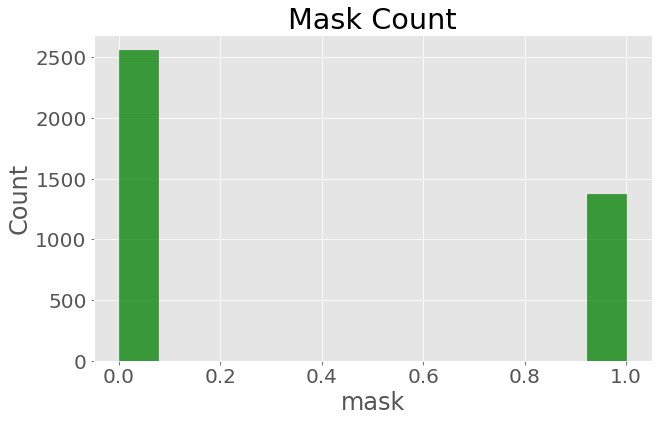

In [22]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
sns.histplot(data=brain_df, x= brain_df['mask'], element="step",  color= 'g')
plt.title('Mask Count')

444

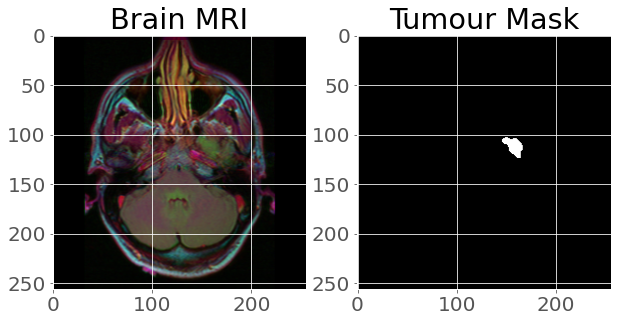

In [23]:
i=0
while i < len(imgs): ## Show one MRI image along with its Mask
    if brain_df['mask'][i]==1:

        img_2_show =brain_df.image_path[i]
        mask_2_show = brain_df.mask_path[i]
        
        break # Break otherwise i will get updated and we only need one image
    else:
        i+=1
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(img_2_show))
plt.title("Brain MRI")
plt.subplot(1,2,2)
plt.imshow(cv2.imread(mask_2_show))
plt.title("Tumour Mask")
i

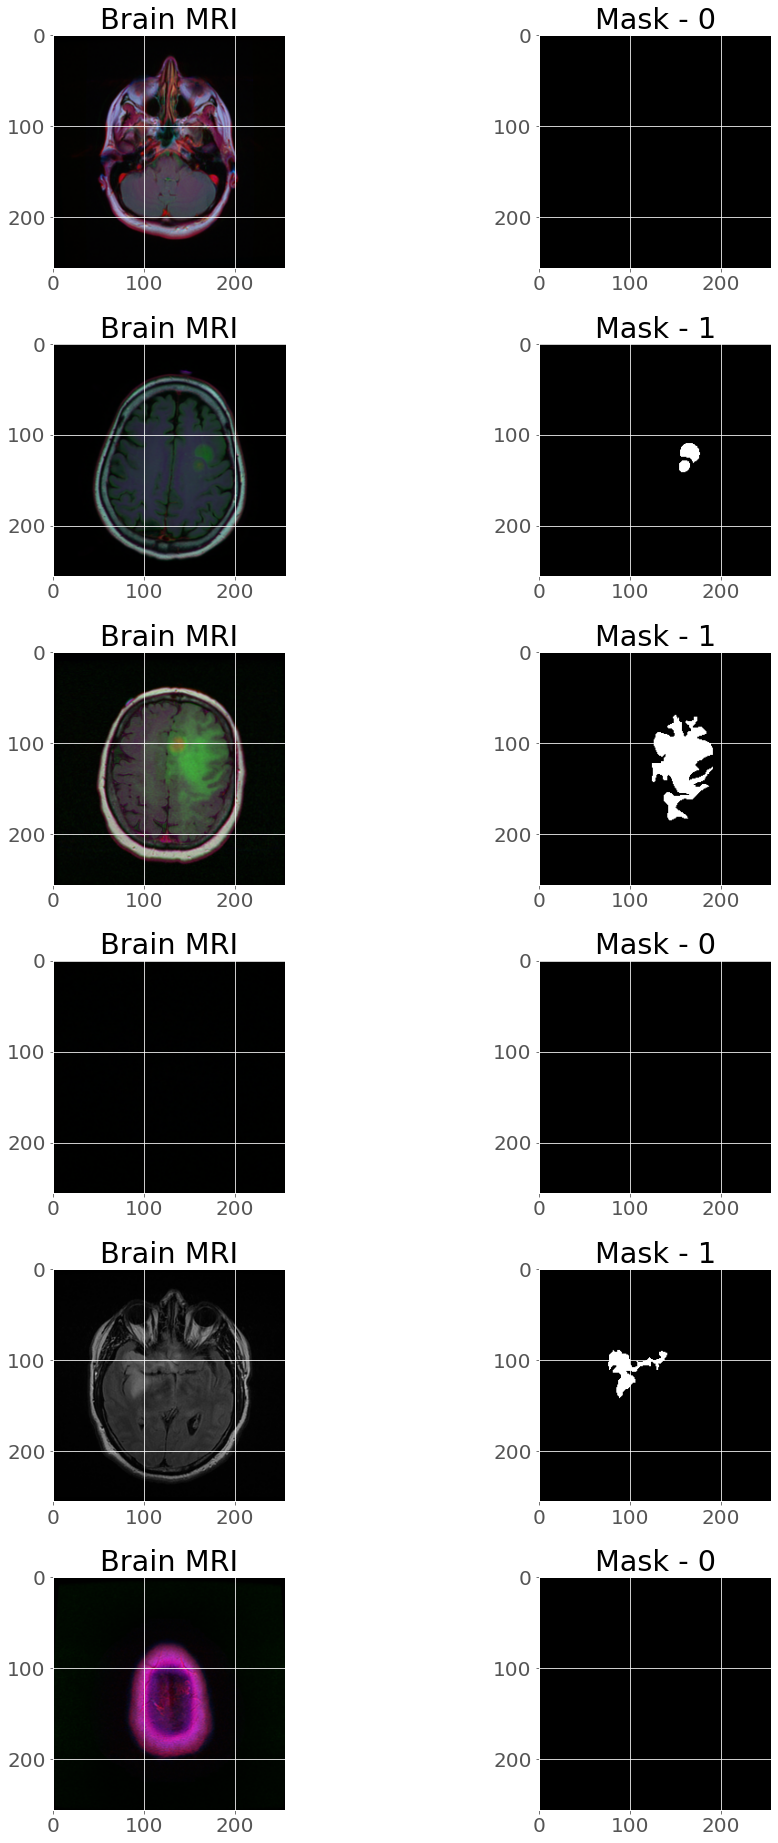

In [24]:
fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

Text(0.5, 1.0, 'Mask')

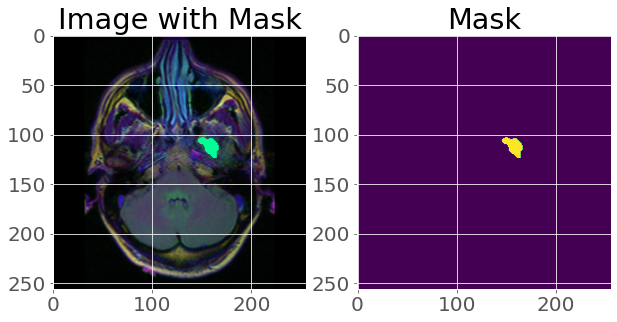

In [25]:
## Overlap mask with the Image (I took the i value from the previous code block)
img = io.imread(brain_df.image_path[444])
msk = io.imread(brain_df.mask_path[444])
img[msk==255]=(0,255,150)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image with Mask')
plt.subplot(1,2,2)
plt.imshow(msk)
plt.title('Mask')


### 3. Test Train Split 

In [26]:
brain_df_train = brain_df.drop(columns=['patient_id'])

In [27]:
from sklearn.model_selection import train_test_split
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [28]:
train, test = train_test_split(brain_df_train, test_size=0.15)

In [29]:
train

image_path  \
1943  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
2441  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
2693  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
1044  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
1914  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
...                                                 ...   
764   C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
2108  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
106   C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
2003  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   
744   C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...   

                                              mask_path mask  
1943  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    1  
2441  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    0  
2693  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    1  
1044  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    0  
1914  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    1  
...                                                 ...  ...  
764   C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    0  
2108  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    0  
106   C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    0  
2003  C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    0  
744   C:\Users\temp\ML\Projects\Mask_RCNN_Brain_MRIs...    1  

[3339 rows x 3 columns]

 (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#used-in-the-notebooks_1)

In [30]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)


In [31]:
## Train and Validation 

train_generator= datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='training',
    class_mode='categorical',
    batch_size=16,
   
    shuffle=True,
    target_size=(256,256)
)
valid_generator = datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='validation',
    class_mode='categorical',
    batch_size=16,
 
    shuffle=True,
    target_size=(256,256)
)

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.


In [33]:
# Test

test_datagen =  ImageDataGenerator(
    rescale=1./255,
)
test_generator = datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col='image_path',
    y_col='mask',
    class_mode='categorical',
    batch_size=1,
    
    shuffle=False,
    target_size=(256,256)
)

Found 590 validated image filenames belonging to 2 classes.


In [34]:
from tensorflow.keras.applications.resnet50 import ResNet50 ## I am using ResNet50. But any famour CNN models can be used

clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

clf_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Classification model to determine whether Tumour exists or not

In [35]:
for layers in clf_model.layers:
    layers.trainable= False


In [37]:

def myModel (Y): ## Defining funcional Api CNN
    X= Y
    X = keras.layers.AveragePooling2D(pool_size=(4,4))(X)
    X = keras.layers.Flatten(name='Flatten')(X)
    X= keras.layers.Dense(256, activation='relu') (X)
    X= keras.layers.Dropout(0.3) (X)
    X= keras.layers.Dense(256, activation='relu') (X)
    X= keras.layers.Dropout(0.3) (X)
    X = keras.layers.Dense(2, activation='softmax')(X)

    return X

In [42]:
X = myModel(clf_model.output) ## Resnet Output will become the input for this model
model= Model(clf_model.input, X)
model.compile (loss = 'categorical_crossentropy',
optimizer='adam',
 metrics= ["accuracy"]
)

In [43]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Fitting the model

In [235]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=10
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_LR = ReduceLROnPlateau(
                              monitor="val_loss",
                              mode='min',
                              verbose =1,
                              factor=0.2,
                              min_delta= 0.0001,
                              patience=10,)


In [236]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100,
                    callbacks=[checkpointer, earlystopping]
)

Epoch 1/100


C:\Users\temp\AppData\Local\Temp/ipykernel_14628/1628849916.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


187/187 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.6201
Epoch 1: val_loss improved from inf to 0.61938, saving model to clf-resnet-weights.hdf5
187/187 [==============================] - 27s 128ms/step - loss: 0.7169 - accuracy: 0.6201 - val_loss: 0.6194 - val_accuracy: 0.6500
Epoch 2/100
187/187 [==============================] - ETA: 0s - loss: 0.6354 - accuracy: 0.6522
Epoch 2: val_loss improved from 0.61938 to 0.59363, saving model to clf-resnet-weights.hdf5
187/187 [==============================] - 23s 124ms/step - loss: 0.6354 - accuracy: 0.6522 - val_loss: 0.5936 - val_accuracy: 0.6531
Epoch 3/100
187/187 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.6508
Epoch 3: val_loss improved from 0.59363 to 0.58428, saving model to clf-resnet-weights.hdf5
187/187 [==============================] - 23s 124ms/step - loss: 0.6035 - accuracy: 0.6508 - val_loss: 0.5843 - val_accuracy: 0.6562
Epoch 4/100
187/187 [==========================

**Validation loss did not improve much and we have exceptionally poor performing Network**

In [237]:
model.save("my_model")


INFO:tensorflow:Assets written to: my_model\assets


In [238]:
dict_model = model.history


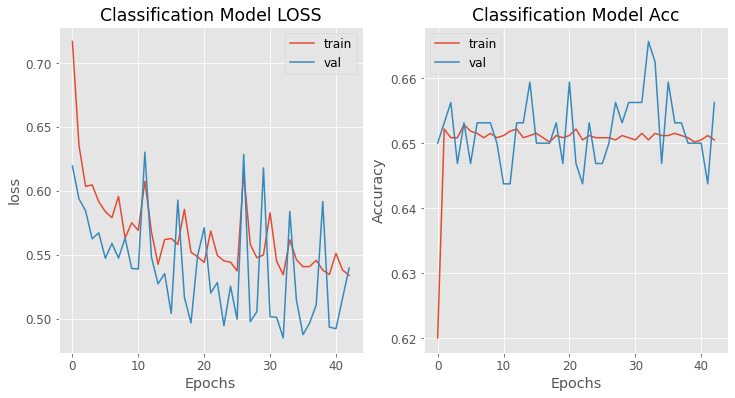

In [239]:
plt.rcParams.update({'font.size':12})
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(dict_model.history['loss']);
plt.plot(dict_model.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(dict_model.history['accuracy']);
plt.plot(dict_model.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [240]:
_, acc = model.evaluate(test_generator)

118/118 [==============================] - 6s 47ms/step - loss: 0.5300 - accuracy: 0.6475


#### Lets Train a VGG Network

In [49]:
from tensorflow.keras.applications.vgg16 import VGG16

VGmodel = VGG16 (input_shape=(256,256,3),
                include_top = False,        
                weights = 'imagenet')

58900480/58889256 [==============================] - 5s 0us/step


In [50]:
for layer in VGmodel.layers: ## We don't want to train the inner layers
    layer.trainable = False

In [53]:
# Lets add similar layers to VGG
x = myModel(VGmodel.output)
model2 = tf.keras.models.Model(VGmodel.input, x)

In [56]:
model2.compile (loss = 'categorical_crossentropy',
optimizer='adam',
 metrics= ["accuracy"]
)

In [57]:
model2.summary() ## VGG model summary

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [58]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=10
                             )
checkpointer = ModelCheckpoint(filepath="clf-vgg-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_LR = ReduceLROnPlateau(
                              monitor="val_loss",
                              mode='min',
                              verbose =1,
                              factor=0.2,
                              min_delta= 0.0001,
                              patience=10,)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
vgghist = model2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=150,
                    callbacks=[checkpointer, earlystopping, reduce_LR]
)




Epoch 1/150


C:\Users\temp\AppData\Local\Temp/ipykernel_10680/57003508.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgghist = model2.fit_generator(generator=train_generator,


187/187 [==============================] - ETA: 0s - loss: 0.5141 - accuracy: 0.7268
Epoch 1: val_loss improved from inf to 0.45166, saving model to clf-vgg-weights.hdf5
187/187 [==============================] - 47s 210ms/step - loss: 0.5141 - accuracy: 0.7268 - val_loss: 0.4517 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 2/150
187/187 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.7689
Epoch 2: val_loss improved from 0.45166 to 0.43650, saving model to clf-vgg-weights.hdf5
187/187 [==============================] - 37s 197ms/step - loss: 0.4430 - accuracy: 0.7689 - val_loss: 0.4365 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 3/150
187/187 [==============================] - ETA: 0s - loss: 0.4238 - accuracy: 0.7793
Epoch 3: val_loss improved from 0.43650 to 0.42600, saving model to clf-vgg-weights.hdf5
187/187 [==============================] - 37s 197ms/step - loss: 0.4238 - accuracy: 0.7793 - val_loss: 0.4260 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 4/150
187/1

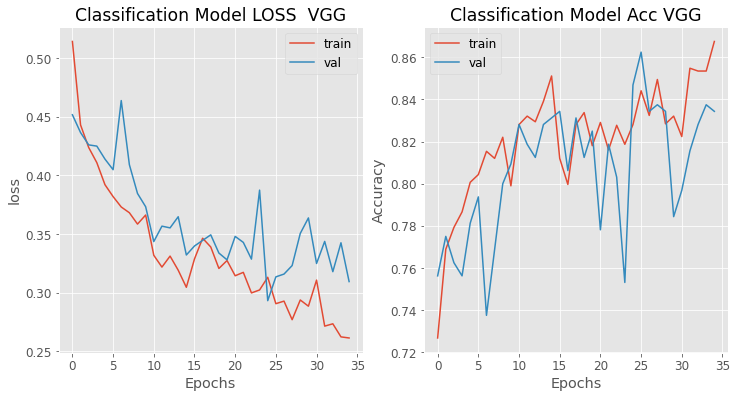

In [61]:
plt.rcParams.update({'font.size':12})
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(vgghist.history['loss']);
plt.plot(vgghist.history['val_loss']);
plt.title("Classification Model LOSS  VGG");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(vgghist.history['accuracy']);
plt.plot(vgghist.history['val_accuracy']);
plt.title("Classification Model Acc VGG");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [63]:
_, acc = model2.evaluate(test_generator)
print("Test accuracy VGG : {} %".format(acc*100))

590/590 [==============================] - 12s 20ms/step - loss: 0.2752 - accuracy: 0.8373
Test accuracy VGG : 83.72881412506104 %
